### Data Description

1.	InvoiceNo:   A unique identifier for each invoice or transaction, often used for
                 tracking and reference purposes.
2.	StockCode:   A code or identifier associated with a specific product or item in the e-
                 commerce store's inventory, used for cataloging and tracking purposes.
3.	Description: A categorical feature that provides a brief textual description of the
                 product or item being sold, offering clarity to customers about what they are
                 purchasing.
4.	Quantity:     The quantity or number of units of a product that were included in the
                   transaction, indicating the purchase volume for each item.
5.	InvoiceDate: The date and time when the transaction or invoice was generated,
                  offering insights into when purchases were made and allowing for temporal
                  analysis.
6.	UnitPrice:     Indicating the total cost of the items purchased.
7.	CustomerID:      A unique identifier associated with each customer or shopper,
                         allowing for customer-specific analysis and tracking of individual purchasing
                         behavior.
8.	Country:      The name of the country where the customer is located or where the
                  transaction occurred.


## Installing all the neccesary Modules

In [1]:
!pip install lifetimes
!pip install xgboost

## Importing all necessary libraries

In [2]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualization and plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Date and time handling
import datetime as dt

# System and utility
from operator import attrgetter

# # Suppress warnings
# import warnings
# warnings.filterwarnings('ignore')

# Customer lifetime value modeling
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data

# Machine learning models and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error

# XGBoost model
import xgboost as xgb


## Data Import

In [3]:
data = pd.read_csv("e_commerce.csv")
print('E-Shop Pro Dataset:')
data.head()

E-Shop Pro Dataset:


,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country
0,536365,01/12/2010 08:26,17850.0,SC1734,Electronics,65,10.23,Egypt
1,536365,01/12/2010 08:26,17850.0,SC2088,Furniture,95,19.61,Mali
2,536365,01/12/2010 08:26,17850.0,SC3463,Books,78,61.49,Mali
3,536365,01/12/2010 08:26,17850.0,SC6228,Toys,15,24.73,South Africa
4,536365,01/12/2010 08:26,17850.0,SC2149,Toys,50,38.83,Rwanda


## Data Cleaning & Preprocessing

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   InvoiceDate  541909 non-null  object 
 2   CustomerID   406829 non-null  float64
 3   StockCode    541909 non-null  object 
 4   Description  541909 non-null  object 
 5   Quantity     541909 non-null  int64  
 6   UnitPrice    541909 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"], dayfirst=True)

In [6]:
data["InvoiceDate"].unique()

array(['2010-12-01T08:26:00.000000000', '2010-12-01T08:28:00.000000000',
       '2010-12-01T08:34:00.000000000', ...,
       '2011-12-09T12:31:00.000000000', '2011-12-09T12:49:00.000000000',
       '2011-12-09T12:50:00.000000000'], dtype='datetime64[ns]')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   InvoiceDate  541909 non-null  datetime64[ns]
 2   CustomerID   406829 non-null  float64       
 3   StockCode    541909 non-null  object        
 4   Description  541909 non-null  object        
 5   Quantity     541909 non-null  int64         
 6   UnitPrice    541909 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [8]:
data.describe()

,CustomerID,Quantity,UnitPrice
count,406829.000000,541909.000000,541909.000000
mean,15287.690570,50.534748,50.476354
std,1713.600303,28.849367,28.564775
min,12346.000000,1.000000,1.000000
25%,13953.000000,26.000000,25.750000
50%,15152.000000,51.000000,50.430000
75%,16791.000000,76.000000,75.180000
max,18287.000000,100.000000,100.000000


In [9]:
# check for the total number of null values

data.isnull().sum()

InvoiceNo           0
InvoiceDate         0
CustomerID     135080
StockCode           0
Description         0
Quantity            0
UnitPrice           0
Country             0
dtype: int64

In [10]:
# delete rows with null values

data.dropna(inplace=True)

In [11]:
# recheck the total number of null values

data.isnull().sum()

InvoiceNo      0
InvoiceDate    0
CustomerID     0
StockCode      0
Description    0
Quantity       0
UnitPrice      0
Country        0
dtype: int64

In [12]:
duplicates = data[data.duplicated()]
print("Duplicate rows:")
print(duplicates)

Duplicate rows:
Empty DataFrame
Columns: [InvoiceNo, InvoiceDate, CustomerID, StockCode, Description, Quantity, UnitPrice, Country]
Index: []


In [13]:
# convert CustomerID data type(float) to integer

data['CustomerID'] = data['CustomerID'].astype(int)


# Exploratory Data Analysis (EDA)

In [14]:
# Total quantity sold (summing across all products)
total_quantity = data['Quantity'].sum()

# Total price (summing UnitPrice * Quantity)
total_price = (data['UnitPrice'] * data['Quantity']).sum()

# Create a new one-row DataFrame to show totals
total_sold = pd.DataFrame({
    'Total_Quantity': [total_quantity],
    'Total_Price': [total_price]
})

total_sold


,Total_Quantity,Total_Price
0,20536106,1.037436e+09


In [15]:
# Group by product description and sum the quantity sold
total_quantity_by_description = data.groupby('Description')['Quantity'].sum().sort_values(ascending=False)

# Convert to DataFrame for better formatting if needed
totals = total_quantity_by_description.reset_index()
totals.columns = ['Description', 'Total_Quantity']

totals


,Description,Total_Quantity
0,Shoes,2069190
1,Jewelry,2065153
2,Toys,2063396
3,Furniture,2063221
4,Sports Equipment,2060571
5,Cloths,2054709
6,Cosmetics,2051088
7,Kitchenware,2046704
8,Electronics,2036733
9,Books,2025341


In [16]:
print('Country count:')

dc = data['Country'].value_counts().reset_index()
dc.head(5)

Country count:


,index,Country
0,Nigeria,14714
1,Sierra Leone,14684
2,Somalia,14656
3,Cote d'Ivoire,14645
4,Mozambique,14639


In [17]:
quantity_per_country = data.groupby(["Country"])["Quantity"].sum().reset_index()
quantity_per_country = quantity_per_country.sort_values("Quantity", ascending = False).reset_index()

In [18]:
print("Quantity of goods sold in a country:")
quantity_per_country.head(5)

Quantity of goods sold in a country:


,index,Country,Quantity
0,23,Togo,741223
1,20,South Africa,740589
2,4,Cote d'Ivoire,740229
3,15,Nigeria,739708
4,9,Libya,739206


<Figure size 1400x700 with 0 Axes>

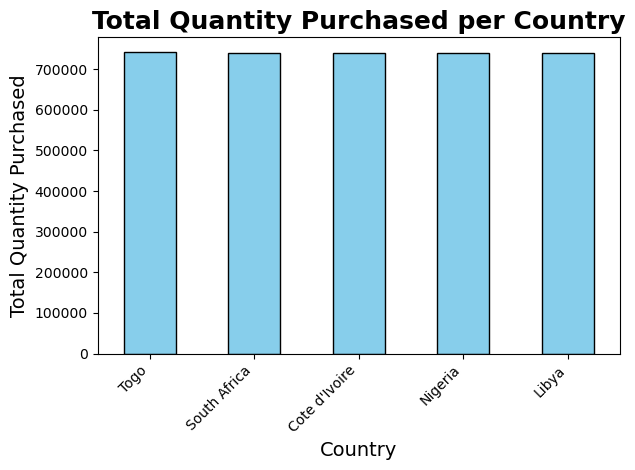

In [19]:
# Sort and plot total quantity per country from a DataFrame
plt.figure(figsize=(14, 7))
quantity_per_country.sort_values(by='Quantity', ascending=False).head(5).plot(
    x='Country', y='Quantity', kind='bar', color='skyblue', edgecolor='black', legend=False
)

plt.title('Total Quantity Purchased per Country', fontsize=18, weight='bold')
plt.xlabel('Country', fontsize=14)
plt.ylabel('Total Quantity Purchased', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [20]:
print("Quantity of goods sold in a country:")
quantity_per_country.tail(5)

Quantity of goods sold in a country:


,index,Country,Quantity
23,10,Madagascar,726297
24,14,Niger,725841
25,22,Tanzania,725664
26,26,Zambia,725152
27,25,Uganda,724525


In [21]:
data["InvoiceDate"].unique()

array(['2010-12-01T08:26:00.000000000', '2010-12-01T08:28:00.000000000',
       '2010-12-01T08:34:00.000000000', ...,
       '2011-12-09T12:31:00.000000000', '2011-12-09T12:49:00.000000000',
       '2011-12-09T12:50:00.000000000'], dtype='datetime64[ns]')

In [22]:
# Draw a plot of top 10 countries with highest number of quantity purchase
top_countries = quantity_per_country.head(10)

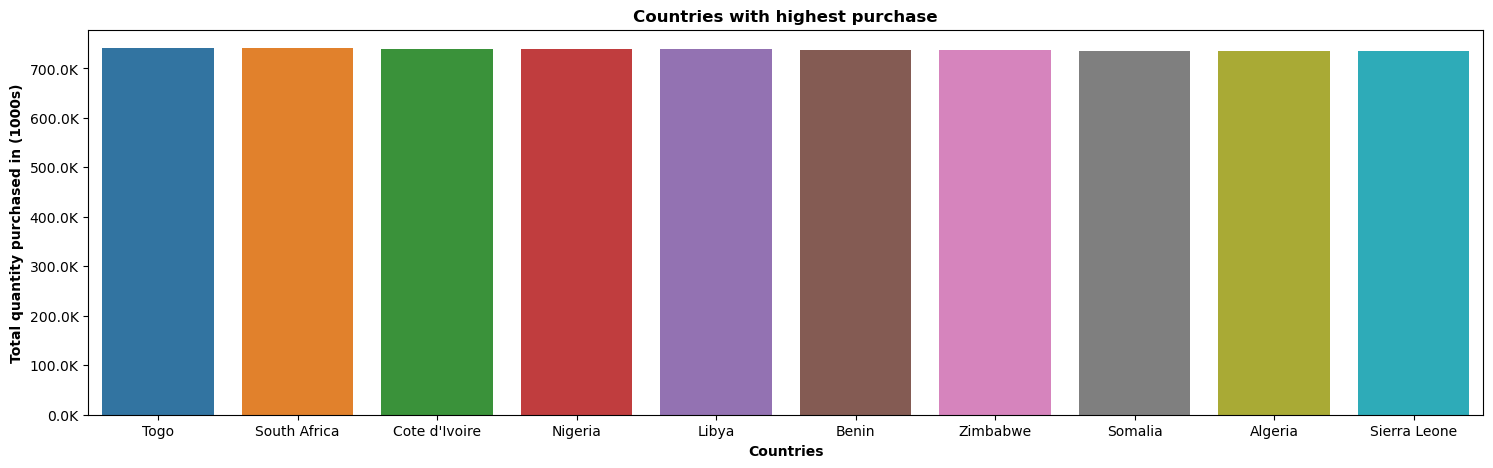

In [23]:

# Create a bar chart from the selected data
plt.figure(figsize=(18, 5))

y_format = FuncFormatter(lambda x, _: f'{x / 1000:.1f}K')
ax = sns.barplot(x='Country', y='Quantity', data= top_countries)
ax.yaxis.set_major_formatter(y_format)

plt.xlabel('Countries', fontweight='bold')
plt.ylabel('Total quantity purchased in (1000s)', fontweight='bold')
plt.title('Countries with highest purchase', fontweight='bold')
plt.show()

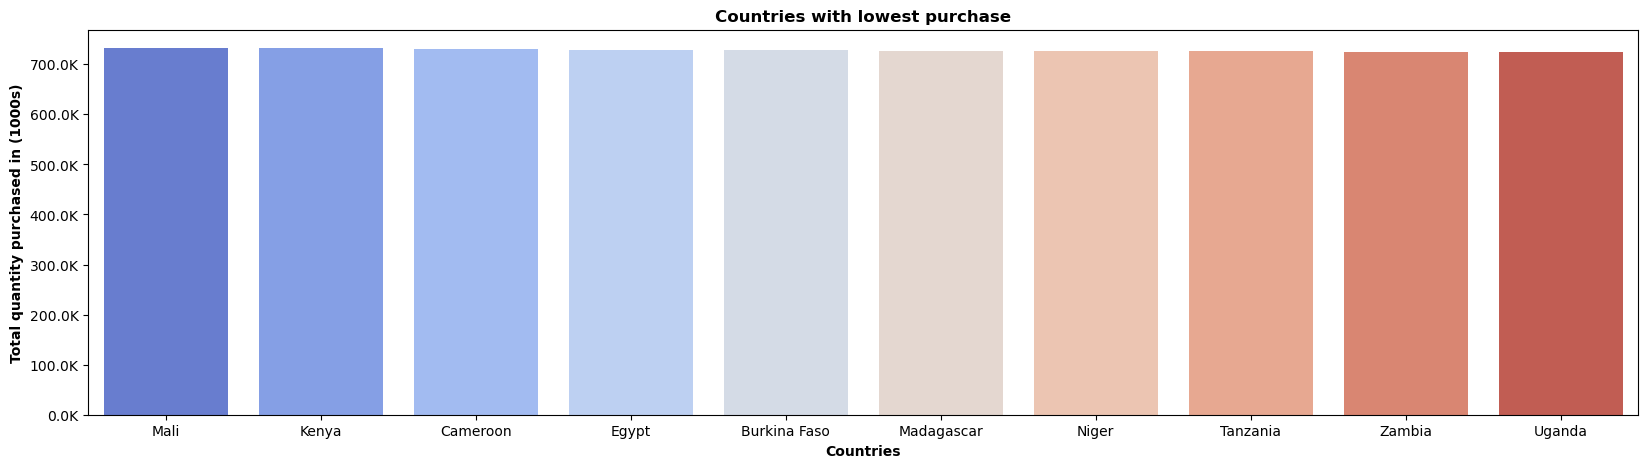

In [24]:
# Draw a plot of 10 countries with least number of quantity purchase
least_10_countries = quantity_per_country.tail(10)

# Create a bar chart from the selected data
plt.figure(figsize=(20, 5))

y_format = FuncFormatter(lambda x, _: f'{x / 1000:.1f}K')
ax = sns.barplot(x='Country', y='Quantity', data= least_10_countries, palette="coolwarm")
ax.yaxis.set_major_formatter(y_format)

plt.xlabel('Countries', fontweight='bold')
plt.ylabel('Total quantity purchased in (1000s)', fontweight='bold')
plt.title('Countries with lowest purchase', fontweight='bold')
plt.show()

In [25]:
# Number of customers per Country

country_to_customers = data.groupby(["Country"])["CustomerID"].nunique().reset_index()
country_to_customers = country_to_customers.sort_values("CustomerID", ascending = False).reset_index()
country_to_customers.rename(columns = {"CustomerID" : "Number of customers"}, inplace = True)

In [26]:
country_to_customers.head(3)

,index,Country,Number of customers
0,13,Mozambique,3072
1,1,Benin,3054
2,23,Togo,3053


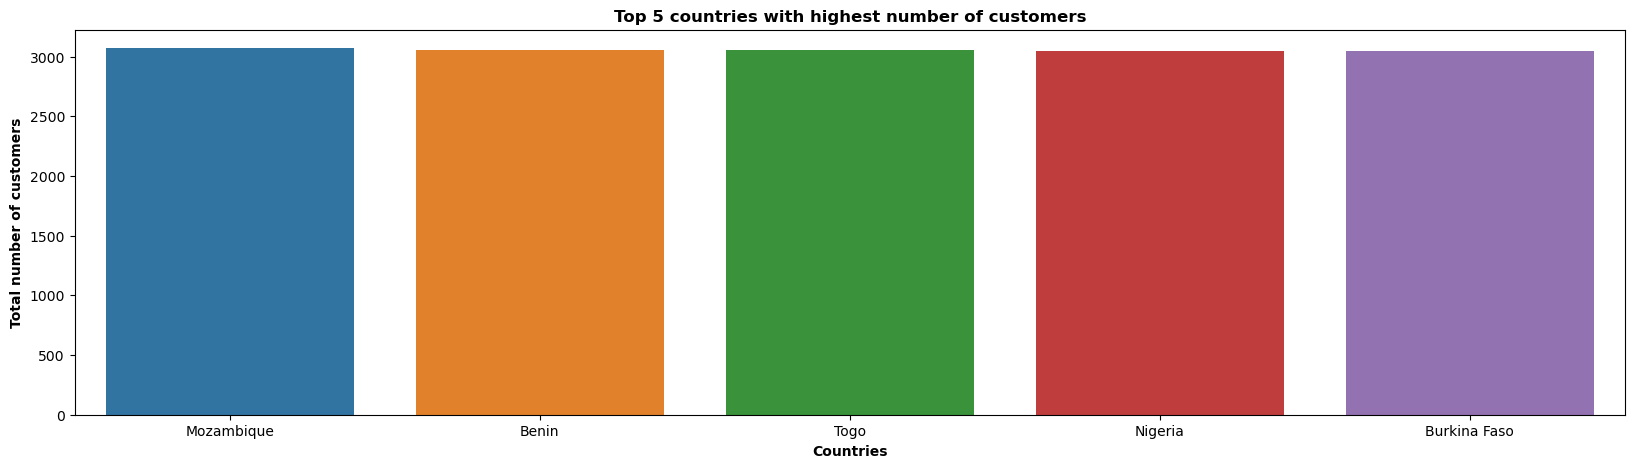

In [27]:
# Draw a plot of top 10 countries with highest number of customers (unique customerID)
top_countries_to_customers = country_to_customers.head(5)

# Create a bar chart from the selected data
plt.figure(figsize=(20, 5))

sns.barplot(x='Country', y='Number of customers', data= top_countries_to_customers)

plt.xlabel('Countries', fontweight='bold')
plt.ylabel('Total number of customers', fontweight='bold')
plt.title('Top 5 countries with highest number of customers', fontweight='bold')
plt.show()

In [28]:
print('Customer ID count:')

data['CustomerID'].value_counts()

Customer ID count:


17841    7983
14911    5903
14096    5128
12748    4642
14606    2782
         ... 
15070       1
15753       1
17065       1
16881       1
16995       1
Name: CustomerID, Length: 4372, dtype: int64

In [29]:
print("Country VS. Customer ID  count:") 

data[['Country','CustomerID']].value_counts()

Country VS. Customer ID  count:


Country       CustomerID
Libya         17841         324
Senegal       17841         311
Burkina Faso  17841         308
Mozambique    17841         303
Uganda        17841         301
                           ... 
Ghana         14022           1
              14024           1
              14037           1
Somalia       14077           1
South Africa  14576           1
Length: 84912, dtype: int64

In [30]:
print("Customer ID VS. Invoice Number count:")

data[['CustomerID','InvoiceNo']].value_counts()

Customer ID VS. Invoice Number count:


CustomerID  InvoiceNo
14096       576339       542
            579196       533
            580727       529
            578270       442
            573576       435
                        ... 
14744       C544590        1
17423       C553486        1
            C572747        1
17425       577553         1
12346       541431         1
Length: 22190, dtype: int64

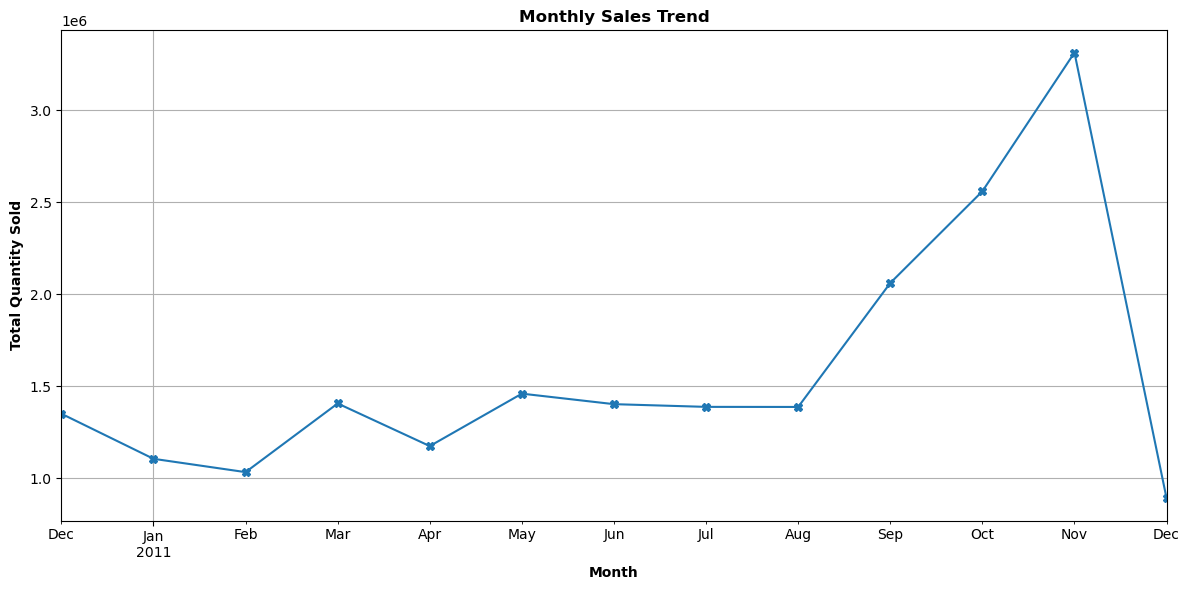

In [31]:
# Calculate monthly sales
monthly_sales = data.groupby(data['InvoiceDate'].dt.to_period('M'))['Quantity'].sum()

# Plot sales trends
monthly_sales.plot(kind='line', figsize=(12, 6), marker='X')
plt.title('Monthly Sales Trend', fontweight='bold')
plt.xlabel('Month', fontweight='bold')
plt.ylabel('Total Quantity Sold', fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()





In [32]:
product_sales = data.groupby('Description')['Quantity'].sum().sort_values(ascending=False)
print(product_sales)


Description
Shoes               2069190
Jewelry             2065153
Toys                2063396
Furniture           2063221
Sports Equipment    2060571
Cloths              2054709
Cosmetics           2051088
Kitchenware         2046704
Electronics         2036733
Books               2025341
Name: Quantity, dtype: int64


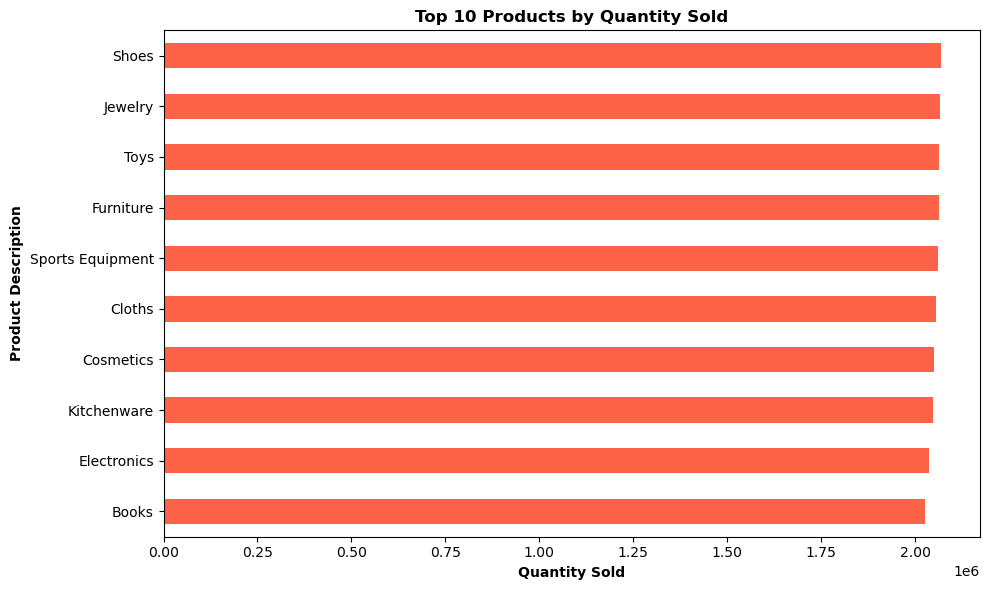

In [33]:
# Plot top 10 selling products
top_products = product_sales.head(10)

top_products.plot(kind='barh', figsize=(10, 6), color='tomato')
plt.title('Top 10 Products by Quantity Sold', fontweight='bold')
plt.xlabel('Quantity Sold', fontweight='bold')
plt.ylabel('Product Description', fontweight='bold')
plt.gca().invert_yaxis()  # Highest at top
plt.tight_layout()
plt.show()


# Cohort Analysis and Customer Retention

In [34]:
data.head(5)

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country
0,536365,2010-12-01 08:26:00,17850,SC1734,Electronics,65,10.23,Egypt
1,536365,2010-12-01 08:26:00,17850,SC2088,Furniture,95,19.61,Mali
2,536365,2010-12-01 08:26:00,17850,SC3463,Books,78,61.49,Mali
3,536365,2010-12-01 08:26:00,17850,SC6228,Toys,15,24.73,South Africa
4,536365,2010-12-01 08:26:00,17850,SC2149,Toys,50,38.83,Rwanda


In [35]:
#create Invoice month as new feature
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

data["InvoiceDate"]  = data["InvoiceDate"].apply(get_month)
data.head()

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country
0,536365,2010-12-01,17850,SC1734,Electronics,65,10.23,Egypt
1,536365,2010-12-01,17850,SC2088,Furniture,95,19.61,Mali
2,536365,2010-12-01,17850,SC3463,Books,78,61.49,Mali
3,536365,2010-12-01,17850,SC6228,Toys,15,24.73,South Africa
4,536365,2010-12-01,17850,SC2149,Toys,50,38.83,Rwanda


In [36]:
def get_cohort_date(data):
    """ this function takes in the dataframe
        and returns the cohort date

        variables:
        data = dataframe
        cohort date = the first date they made a purchase
        """

    # assign the minimum date to all unique candidateID, i.e the first day they made a purchase
    data["cohort date"] = data.groupby("CustomerID")["InvoiceDate"].transform("min")
    return data["cohort date"]

#apply the function created to our dataframe and extract the 2 newly created column

data["cohort date"] = get_cohort_date(data)

In [37]:
data

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country,cohort date
0,536365,2010-12-01,17850,SC1734,Electronics,65,10.23,Egypt,2010-12-01
1,536365,2010-12-01,17850,SC2088,Furniture,95,19.61,Mali,2010-12-01
2,536365,2010-12-01,17850,SC3463,Books,78,61.49,Mali,2010-12-01
3,536365,2010-12-01,17850,SC6228,Toys,15,24.73,South Africa,2010-12-01
4,536365,2010-12-01,17850,SC2149,Toys,50,38.83,Rwanda,2010-12-01
...,...,...,...,...,...,...,...,...,...
541904,581587,2011-12-01,12680,SC5440,Furniture,25,36.53,Mozambique,2011-08-01
541905,581587,2011-12-01,12680,SC3576,Cloths,94,90.65,Tunisia,2011-08-01
541906,581587,2011-12-01,12680,SC5283,Furniture,14,40.07,Somalia,2011-08-01
541907,581587,2011-12-01,12680,SC1099,Cosmetics,45,79.83,Senegal,2011-08-01


In [38]:
def get_year_and_month(data, col):
    """
    This function takes in the dataframe and column,
    and returns the month and year component for that column

    Variables:
    data = dataframe
    col = column
    month = month component
    year = year component"""

    month = data[col].dt.month
    year = data[col].dt.year
    return month, year
# apply the fucntion on cohort first date column
first_month, first_year = get_year_and_month(data,"cohort date")

In [39]:
first_month

0         12
1         12
2         12
3         12
4         12
          ..
541904     8
541905     8
541906     8
541907     8
541908     8
Name: cohort date, Length: 406829, dtype: int64

In [40]:
first_year

0         2010
1         2010
2         2010
3         2010
4         2010
          ... 
541904    2011
541905    2011
541906    2011
541907    2011
541908    2011
Name: cohort date, Length: 406829, dtype: int64

In [41]:
# apply the fucntion on cohort latest date column
latest_month, latest_year = get_year_and_month(data,"InvoiceDate")

In [42]:
latest_month

0         12
1         12
2         12
3         12
4         12
          ..
541904    12
541905    12
541906    12
541907    12
541908    12
Name: InvoiceDate, Length: 406829, dtype: int64

In [43]:
# write a function to create cohort index
def create_cohort_index(first_month, first_year, latest_month,latest_year):
    """
    This code creates takes in the first and latest month and year
    and returns the calculated period(in months) the customer has been active

    variables:
    first_month: first month the customer made purchase
    first_year: first year the customer made purchase

    latest_month: recent month the customer made purchase
    latest_year: recent year the customer made purchase

    index: The duration between first and latest purchase (in months)"""

    year_diff = latest_year - first_year
    month_diff = latest_month - first_month
    index = year_diff * 12 + month_diff +1 # +1 is added because of customers who have been active for just 1 month
    return index

In [44]:
data["cohort_index"] = create_cohort_index(first_month, first_year, latest_month, latest_year)

In [45]:
data

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country,cohort date,cohort_index
0,536365,2010-12-01,17850,SC1734,Electronics,65,10.23,Egypt,2010-12-01,1
1,536365,2010-12-01,17850,SC2088,Furniture,95,19.61,Mali,2010-12-01,1
2,536365,2010-12-01,17850,SC3463,Books,78,61.49,Mali,2010-12-01,1
3,536365,2010-12-01,17850,SC6228,Toys,15,24.73,South Africa,2010-12-01,1
4,536365,2010-12-01,17850,SC2149,Toys,50,38.83,Rwanda,2010-12-01,1
...,...,...,...,...,...,...,...,...,...,...
541904,581587,2011-12-01,12680,SC5440,Furniture,25,36.53,Mozambique,2011-08-01,5
541905,581587,2011-12-01,12680,SC3576,Cloths,94,90.65,Tunisia,2011-08-01,5
541906,581587,2011-12-01,12680,SC5283,Furniture,14,40.07,Somalia,2011-08-01,5
541907,581587,2011-12-01,12680,SC1099,Cosmetics,45,79.83,Senegal,2011-08-01,5


In [46]:
cohort_info = data.groupby(["cohort date","cohort_index"])["CustomerID"].nunique().reset_index()

# Rename the column name
cohort_info.rename(columns = {"CustomerID": "Number of customers"}, inplace = True)
cohort_info

,cohort date,cohort_index,Number of customers
0,2010-12-01,1,948
1,2010-12-01,2,362
2,2010-12-01,3,317
3,2010-12-01,4,367
4,2010-12-01,5,341
...,...,...,...
86,2011-10-01,2,93
87,2011-10-01,3,46
88,2011-11-01,1,321
89,2011-11-01,2,43


In [47]:
# create a pivot table

cohort_table = cohort_info.pivot(index = "cohort date", columns = ["cohort_index"], values = "Number of customers")

#change index to understandable format
cohort_table.index = cohort_table.index.strftime('%B %Y')
cohort_table

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort date,,,,,,,,,,,,,
December 2010,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
January 2011,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
February 2011,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
March 2011,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
April 2011,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
May 2011,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
June 2011,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
July 2011,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
August 2011,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


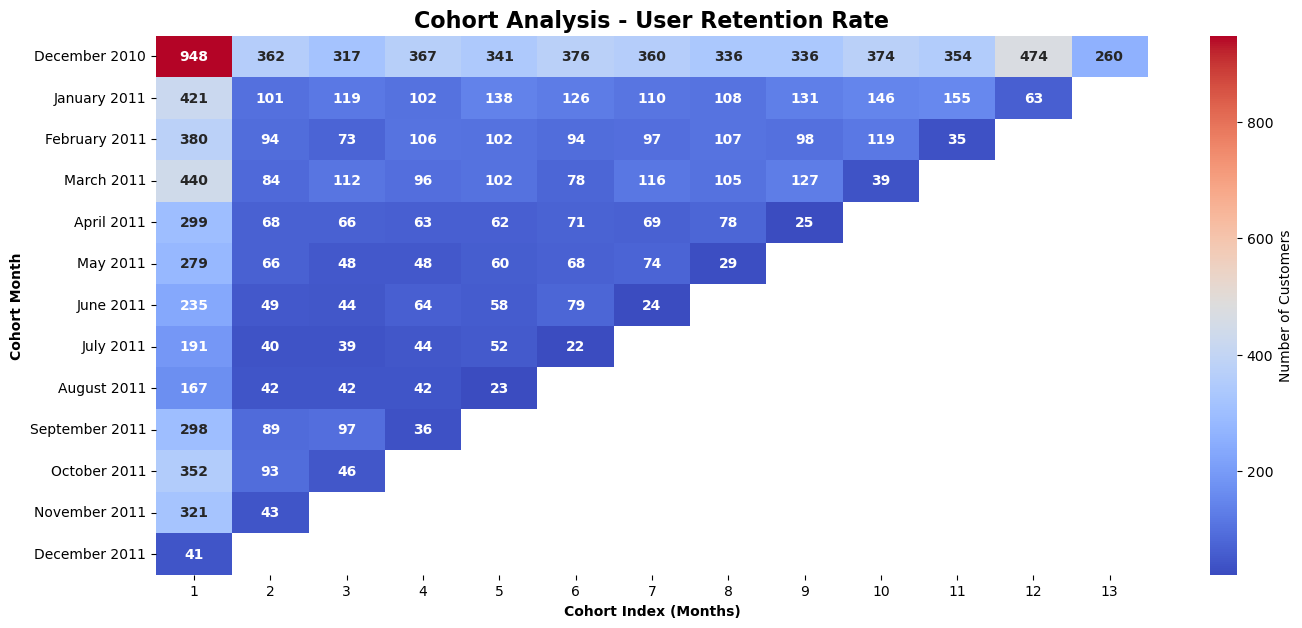

In [48]:
plt.figure(figsize=(16, 7))
sns.heatmap(cohort_table, 
            annot=True, 
            fmt='g', 
            cmap= 'coolwarm', 
            annot_kws={"fontweight": "bold", "fontsize": 10}, cbar_kws={'label': 'Number of Customers'})

plt.title('Cohort Analysis - User Retention Rate', fontweight='bold', fontsize=16)
plt.xlabel('Cohort Index (Months)', fontweight='bold')
plt.ylabel('Cohort Month', fontweight='bold')
plt.show()


In [49]:
# showing retention rate in percentage
new_cohort_table = cohort_table.divide(cohort_table.iloc[:,0], axis = 0)
new_cohort_table

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort date,,,,,,,,,,,,,
December 2010,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
January 2011,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
February 2011,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
March 2011,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
April 2011,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
May 2011,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
June 2011,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
July 2011,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
August 2011,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


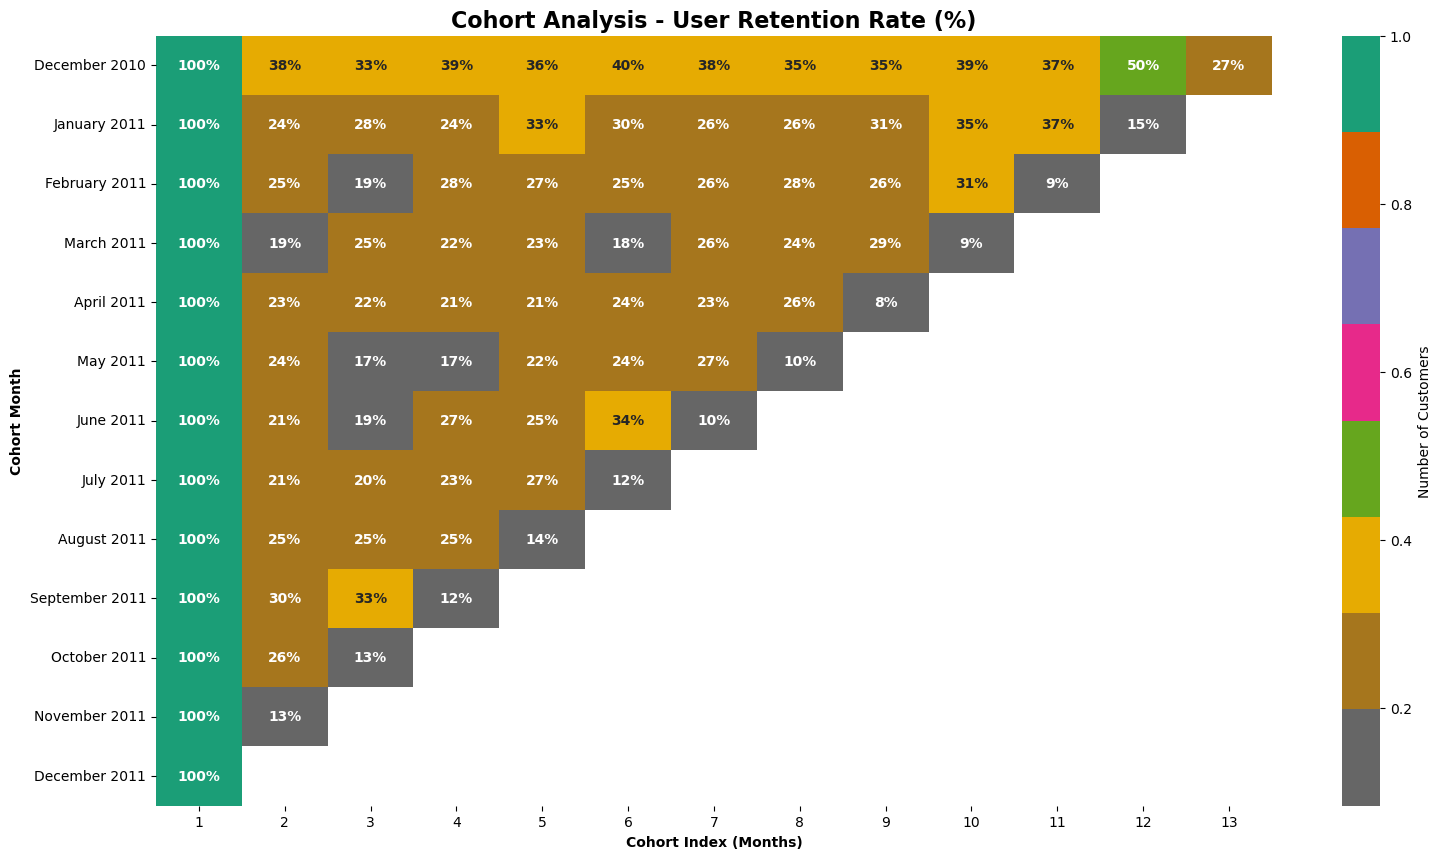

In [50]:
#visualize our results in heatmap

plt.figure(figsize = (18,10))
sns.heatmap(new_cohort_table, 
            annot=True, 
            fmt='.0%', 
            cmap= 'Dark2_r', 
            annot_kws={"fontweight": "bold", "fontsize": 10},cbar_kws={'label': 'Number of Customers'})


plt.title('Cohort Analysis - User Retention Rate (%)', fontweight='bold', fontsize=16)
plt.xlabel('Cohort Index (Months)', fontweight='bold')
plt.ylabel('Cohort Month', fontweight='bold')
plt.show()

In [51]:
# Count unique customers per cohort and period
cohort_data = data.groupby(['cohort date', 'cohort_index'])['CustomerID'].nunique().reset_index()

# Create retention matrix
cohort_counts = cohort_data.pivot(index='cohort date', columns='cohort_index', values='CustomerID')

# Calculate retention rate as a percentage of the first column
first_period = cohort_counts.iloc[:, 0]  # Gets the first actual column
retention = cohort_counts.divide(first_period, axis=0)

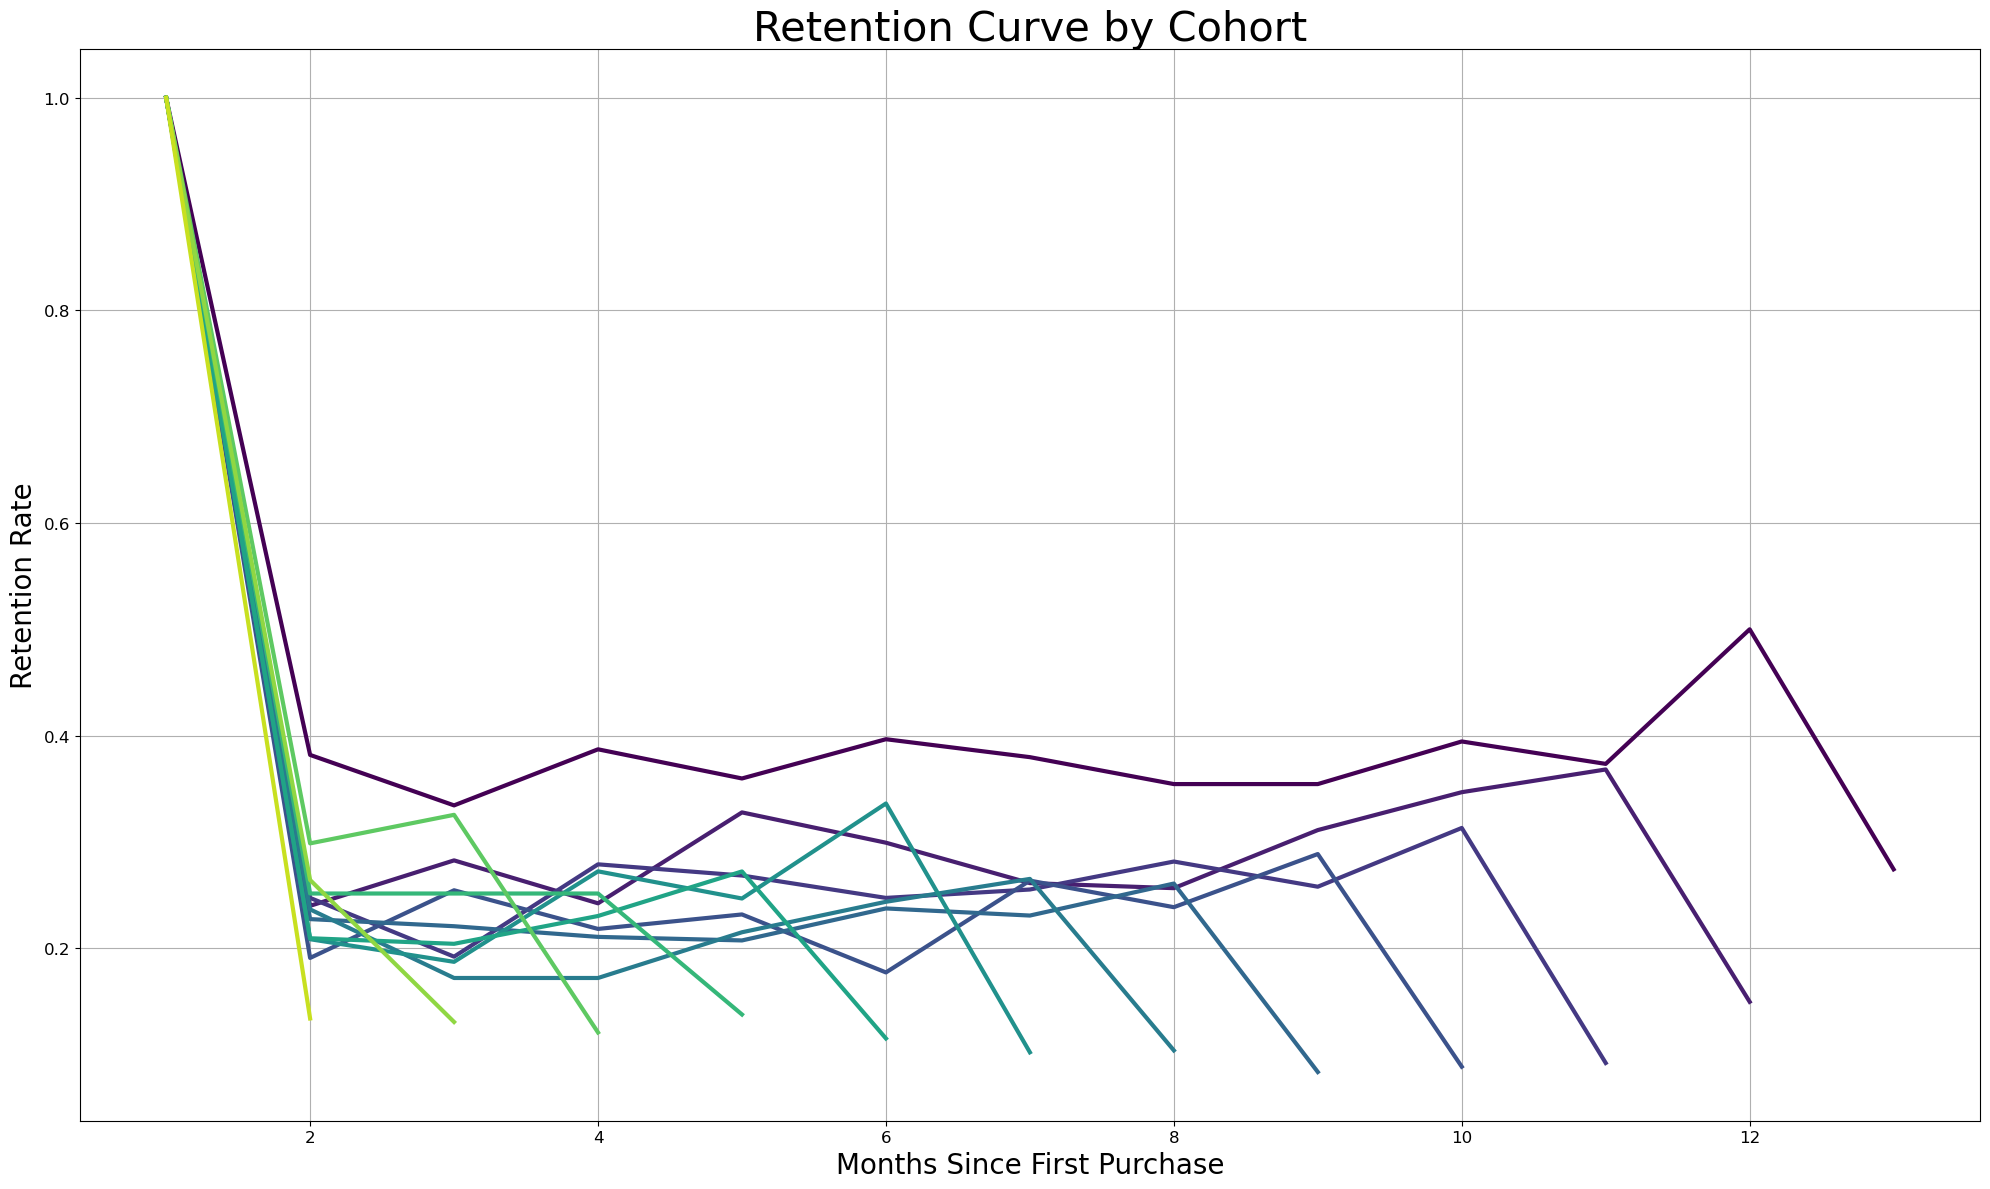

In [52]:
# Set the figure size inside the plot call
retention.T.plot(legend=False, cmap='viridis', linewidth=3, figsize=(20, 12))

plt.title('Retention Curve by Cohort', fontsize=30)
plt.xlabel('Months Since First Purchase', fontsize=20)
plt.ylabel('Retention Rate', fontsize=20)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()

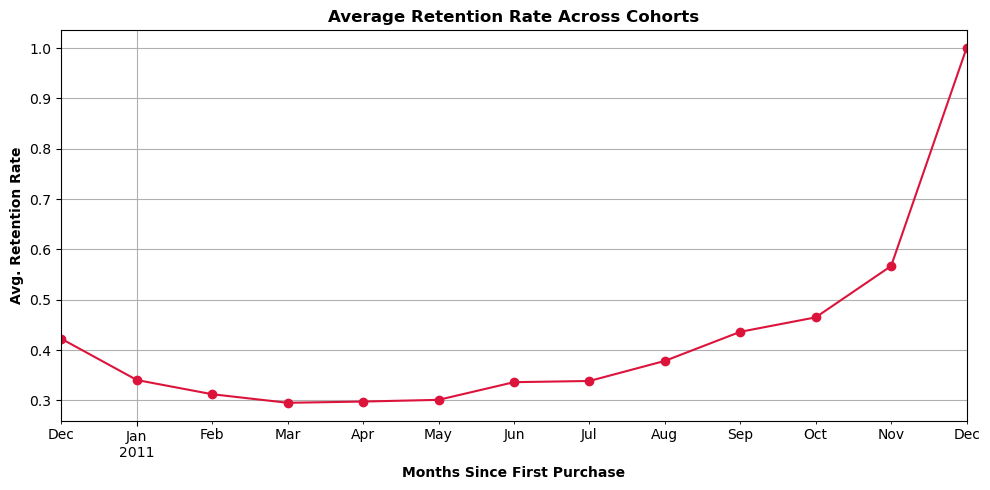

In [53]:
avg_retention = retention.mean(axis=1)  # Average retention per month since acquisition

plt.figure(figsize=(10, 5))
avg_retention.plot(marker='o', linestyle='-', color='crimson')

plt.title('Average Retention Rate Across Cohorts', fontweight='bold')
plt.xlabel('Months Since First Purchase', fontweight='bold')
plt.ylabel('Avg. Retention Rate', fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

## Churn Timing

In [54]:
# Set a churn threshold (e.g., 20% retention)
churn_threshold = 0.20

# Identify cohorts that fall below the churn threshold
churn_timing = retention.apply(lambda x: (x < churn_threshold).idxmax(), axis=1)

# Display churn timing for each cohort (the month they fall below the threshold)
print(churn_timing)

cohort date
2010-12-01     1
2011-01-01    12
2011-02-01     3
2011-03-01     2
2011-04-01     9
2011-05-01     3
2011-06-01     3
2011-07-01     6
2011-08-01     5
2011-09-01     4
2011-10-01     3
2011-11-01     2
2011-12-01     1
dtype: int64


## Customer Value Metrics (RFM & Tenure): Profiling for Retention & Revenue Growth

In [55]:

# Set trans date as the day after the last transaction
trans_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM + Tenure
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': [
        lambda x: (trans_date - x.max()).days,     # Recency
        lambda x: (trans_date - x.min()).days,     # Tenure
    ],
    'InvoiceNo': 'nunique',                           # Frequency
    'Quantity': 'sum'                                 # Monetary (proxy)
})

# Rename columns
rfm.columns = ['Recency', 'Tenure', 'Frequency', 'Total Quantiy Purchased']
rfm = rfm.reset_index()
rfm

,CustomerID,Recency,Tenure,Frequency,Total Quantiy Purchased
0,12346,335,335,2,119
1,12347,1,366,7,8511
2,12348,92,366,4,1539
3,12349,31,31,1,3434
4,12350,304,304,1,917
...,...,...,...,...,...
4367,18280,276,276,1,495
4368,18281,184,184,1,379
4369,18282,1,123,3,786
4370,18283,1,335,16,40533


In [56]:
# Create TotalPrice column
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# RFM with Monetary based on actual revenue
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': [
        lambda x: (trans_date - x.max()).days,     # Recency
        lambda x: (trans_date - x.min()).days,     # Tenure
    ],
    'InvoiceNo': 'nunique',                           # Frequency
    'TotalPrice': 'sum'                               # Monetary (actual)
})

rfm.columns = ['Recency', 'Tenure', 'Frequency', 'Monetary']
rfm = rfm.reset_index()


In [57]:
rfm

,CustomerID,Recency,Tenure,Frequency,Monetary
0,12346,335,335,2,5342.40
1,12347,1,366,7,431501.00
2,12348,92,366,4,82378.47
3,12349,31,31,1,176075.12
4,12350,304,304,1,48173.37
...,...,...,...,...,...
4367,18280,276,276,1,18907.36
4368,18281,184,184,1,26009.01
4369,18282,1,123,3,36010.74
4370,18283,1,335,16,2008747.62


In [58]:
# Recency score (lower is better)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])

# Frequency score (higher is better)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])

# Monetary score (higher is better)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

# Combine into RFM segment
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Optionally: Add an RFM score total
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int).sum(axis=1)


In [59]:
# how to save RFM to excel file
rfm.to_excel('customer_rfm_scored.xlsx', index=False)



## Train BG/NBD model using RFM features, validate with spend data

In [60]:
data.head(5)

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country,cohort date,cohort_index,TotalPrice
0,536365,2010-12-01,17850,SC1734,Electronics,65,10.23,Egypt,2010-12-01,1,664.95
1,536365,2010-12-01,17850,SC2088,Furniture,95,19.61,Mali,2010-12-01,1,1862.95
2,536365,2010-12-01,17850,SC3463,Books,78,61.49,Mali,2010-12-01,1,4796.22
3,536365,2010-12-01,17850,SC6228,Toys,15,24.73,South Africa,2010-12-01,1,370.95
4,536365,2010-12-01,17850,SC2149,Toys,50,38.83,Rwanda,2010-12-01,1,1941.50


In [61]:
# Train BG/NBD model using RFM features, validate with spend data

In [62]:
# Step 1: Prepare the summary RFM-style data
summary = summary_data_from_transaction_data(data, 'CustomerID', 'InvoiceDate',
                                             monetary_value_col='Quantity',  # use actual spend if available
                                             observation_period_end=None, freq='D')

# Remove rows with 0 monetary value (Gamma-Gamma requires positive values)
summary = summary[summary['monetary_value'] > 0]

# Step 2: Fit the BG/NBD model
bgf = BetaGeoFitter()
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# Step 3: Fit the Gamma-Gamma model
ggf = GammaGammaFitter()
ggf.fit(summary['frequency'], summary['monetary_value'])

# Step 4: Predict expected average profit (spend) for each customer
summary['predicted_spend'] = ggf.conditional_expected_average_profit(
    summary['frequency'],
    summary['monetary_value']
)

# Optional: calculate customer lifetime value (CLV)
summary['predicted_clv'] = ggf.customer_lifetime_value(
    bgf,
    summary['frequency'],
    summary['recency'],
    summary['T'],
    summary['monetary_value'],
    time=6,  # months
    discount_rate=0.01
)


C:\Users\user\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [63]:
# Round the relevant columns to 1 decimal point
summary['predicted_spend'] = summary['predicted_spend'].round(1)
summary['predicted_clv'] = summary['predicted_clv'].round(1)

# If you want to round all numeric columns to 1 decimal point:
summary = summary.round(1)

# Show the rounded summary
summary.head()


,frequency,recency,T,monetary_value,predicted_spend,predicted_clv
CustomerID,,,,,,
12347,6.0,365.0,365.0,1162.2,1237.3,3025.3
12348,3.0,274.0,365.0,204.3,789.8,1459.0
12352,3.0,273.0,303.0,1452.0,1422.4,2828.5
12356,2.0,304.0,334.0,617.0,1076.7,1839.8
12358,1.0,153.0,153.0,325.0,1119.6,2142.5


## Calculate Actual Purchases and Tenure, then Merge with Predicted

In [64]:
# Calculate actual purchases (if not done already)
actual_purchases_df = data.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique'  # Total unique invoices (purchases)
}).reset_index()
actual_purchases_df.columns = ['CustomerID', 'actual_purchases']

# Calculate tenure (actual number of days a customer has been active)
tenure_df = data.groupby('CustomerID').agg({
    'InvoiceDate': [min, max]
}).reset_index()
tenure_df['tenure_days'] = (tenure_df[('InvoiceDate', 'max')] - tenure_df[('InvoiceDate', 'min')]).dt.days

# Merge actual purchases and tenure with the summary data
comparison_df = summary.merge(actual_purchases_df, on='CustomerID', how='inner')
comparison_df = comparison_df.merge(tenure_df[['CustomerID', 'tenure_days']], on='CustomerID', how='inner')

# Calculate predicted purchases (BG/NBD model)
comparison_df['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    30,  # Predict purchases in next 30 days
    comparison_df['frequency'],
    comparison_df['recency'],
    comparison_df['T']
)


actual_purchases_df.head(5)

,CustomerID,actual_purchases
0,12346,2
1,12347,7
2,12348,4
3,12349,1
4,12350,1


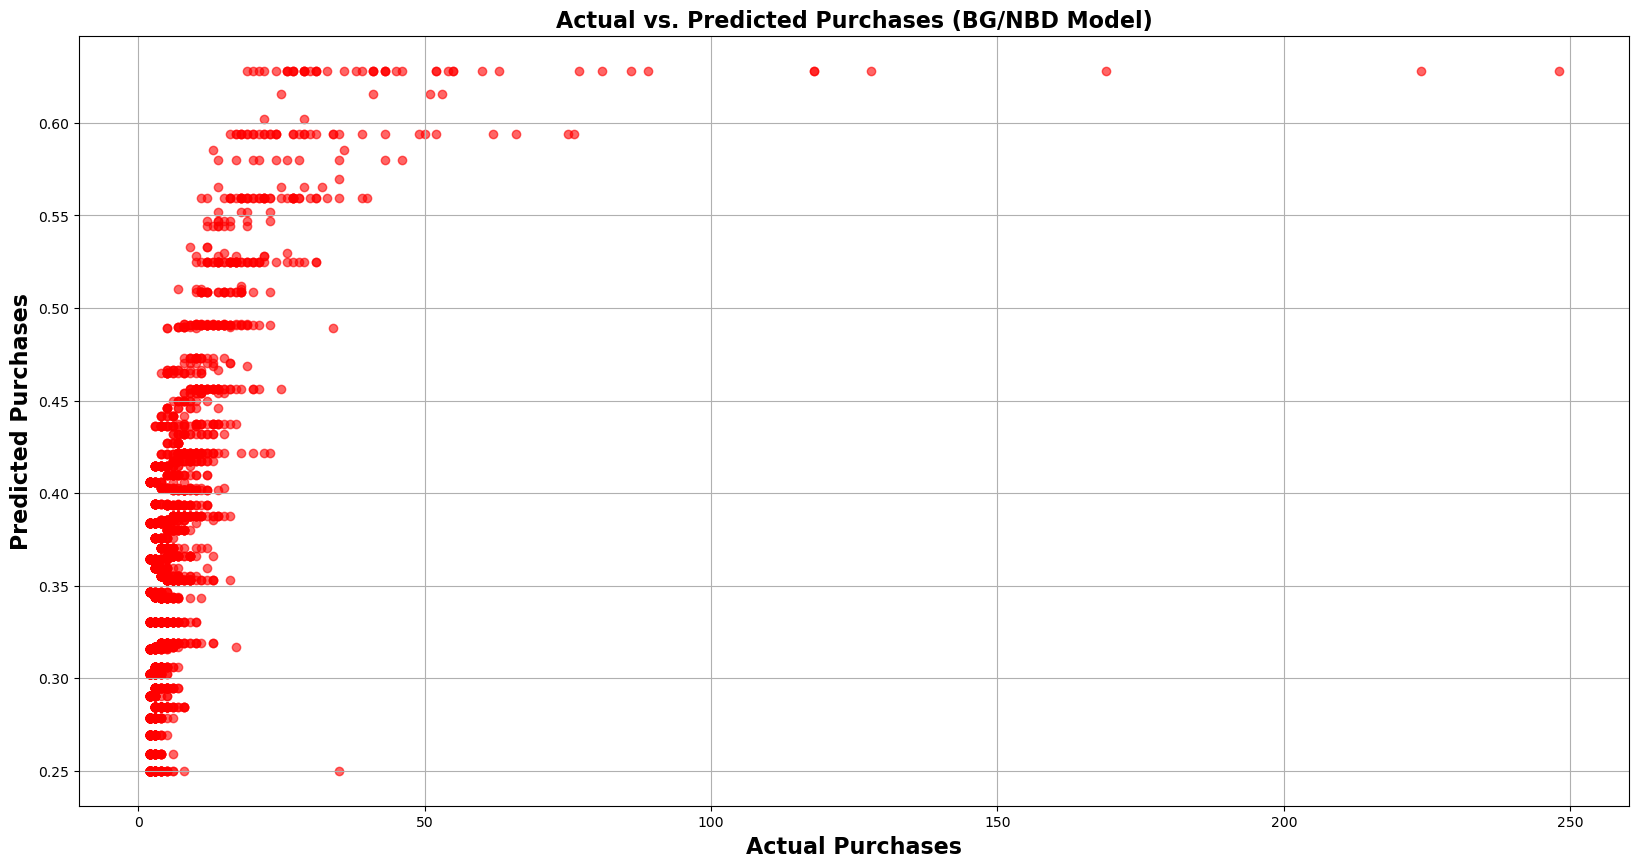

In [65]:
# Plot: Actual Purchases vs. Predicted Purchases
plt.figure(figsize=(20, 10))
plt.scatter(comparison_df['actual_purchases'], comparison_df['predicted_purchases'],color= "Red", alpha=0.6)
plt.xlabel('Actual Purchases', fontweight = "bold", fontsize = 16)
plt.ylabel('Predicted Purchases', fontweight = "bold", fontsize = 16)
plt.title('Actual vs. Predicted Purchases (BG/NBD Model)', fontweight = "bold", fontsize = 16)
plt.grid(True)
plt.show()


In [66]:
print(tenure_df)


     CustomerID InvoiceDate            tenure_days
                        min        max            
0         12346  2011-01-01 2011-01-01           0
1         12347  2010-12-01 2011-12-01         365
2         12348  2010-12-01 2011-09-01         274
3         12349  2011-11-01 2011-11-01           0
4         12350  2011-02-01 2011-02-01           0
...         ...         ...        ...         ...
4367      18280  2011-03-01 2011-03-01           0
4368      18281  2011-06-01 2011-06-01           0
4369      18282  2011-08-01 2011-12-01         122
4370      18283  2011-01-01 2011-12-01         334
4371      18287  2011-05-01 2011-10-01         153

[4372 rows x 4 columns]


In [67]:
# Calculate the monetary value as total spend per transaction (Quantity * UnitPrice)
data['Monetary'] = data['Quantity'] * data['UnitPrice']

# Step 1: Recency - the days since the customer's last purchase
max_date = data['InvoiceDate'].max()
data['Recency'] = (max_date - data['InvoiceDate']).dt.days

# Step 2: Frequency - total number of transactions (unique InvoiceNo) per customer
frequency_df = data.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique'
}).reset_index()
frequency_df.columns = ['CustomerID', 'Frequency']

# Step 3: Monetary - total spend per customer (total of Monetary column)
monetary_df = data.groupby('CustomerID').agg({
    'Monetary': 'sum'
}).reset_index()
monetary_df.columns = ['CustomerID', 'Monetary']

# Merge Recency, Frequency, and Monetary into a single DataFrame
rfm_df = frequency_df.merge(monetary_df, on='CustomerID', how='inner')
rfm_df['Recency'] = data.groupby('CustomerID')['Recency'].max().reset_index(drop=True)

# Check the first few rows to verify
print(rfm_df.head())

   CustomerID  Frequency   Monetary  Recency
0       12346          2    5342.40      334
1       12347          7  431501.00      365
2       12348          4   82378.47      365
3       12349          1  176075.12       30
4       12350          1   48173.37      303


## Train Random Forest & XGBoost model

In [68]:
# Features and target for Random Forest
X = rfm_df[['Recency', 'Frequency']]  # Using Recency and Frequency as features
y_monetary = rfm_df['Monetary']  # Predicting Monetary (spend)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_monetary, test_size=0.2, random_state=42)


# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
rf_predictions = rf_model.predict(X_test)

# Evaluate using MAE and RMSE
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)

print(f"Random Forest - MAE: {rf_mae}, RMSE: {rf_rmse}")

# Train XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
xgb_predictions = xgb_model.predict(X_test)

# Evaluate using MAE and RMSE
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = mean_squared_error(y_test, xgb_predictions, squared=False)

print(f"XGBoost - MAE: {xgb_mae}, RMSE: {xgb_rmse}")


Random Forest - MAE: 151154.63432816436, RMSE: 538394.5381122715
XGBoost - MAE: 161810.5261742857, RMSE: 585790.1743322695


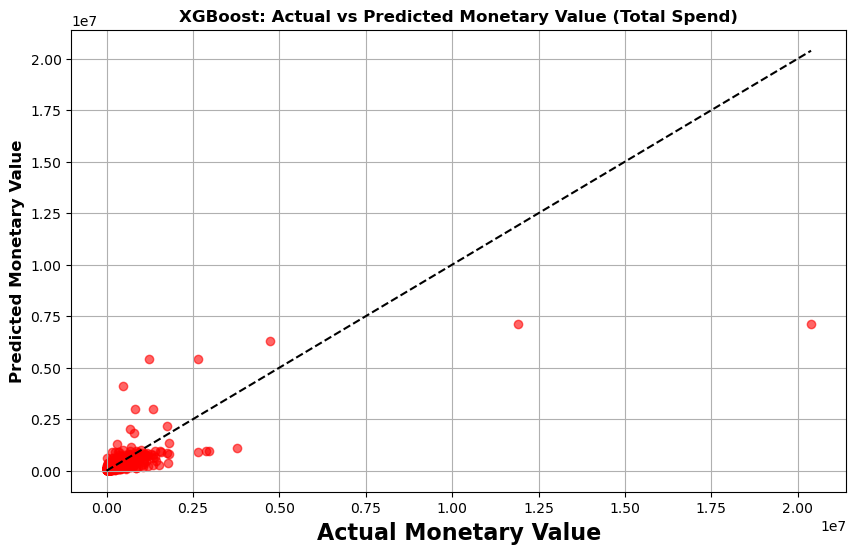

In [69]:
# Plot: Actual vs Predicted Monetary (Total Spend)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_predictions, alpha=0.6, color='red')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')
plt.xlabel('Actual Monetary Value', fontweight = "bold", fontsize = 16)
plt.ylabel('Predicted Monetary Value', fontweight = "bold", fontsize = 12)
plt.title('XGBoost: Actual vs Predicted Monetary Value (Total Spend)',fontweight = "bold")
plt.grid(True)
plt.show()

In [70]:

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)

# Train XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = mean_squared_error(y_test, xgb_predictions, squared=False)


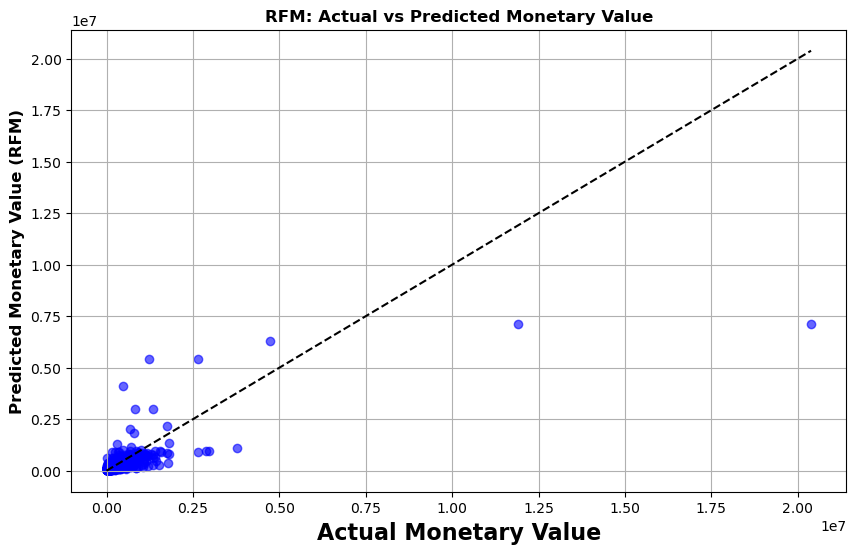

In [71]:
# Plot: Actual vs Predicted Monetary (Total Spend) for RFM Model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_predictions, alpha=0.6, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')
plt.xlabel('Actual Monetary Value', fontweight = "bold", fontsize = 16)
plt.ylabel('Predicted Monetary Value (RFM)', fontweight = "bold", fontsize = 12)
plt.title('RFM: Actual vs Predicted Monetary Value', fontweight = "bold", fontsize = 12)
plt.grid(True)
plt.show()

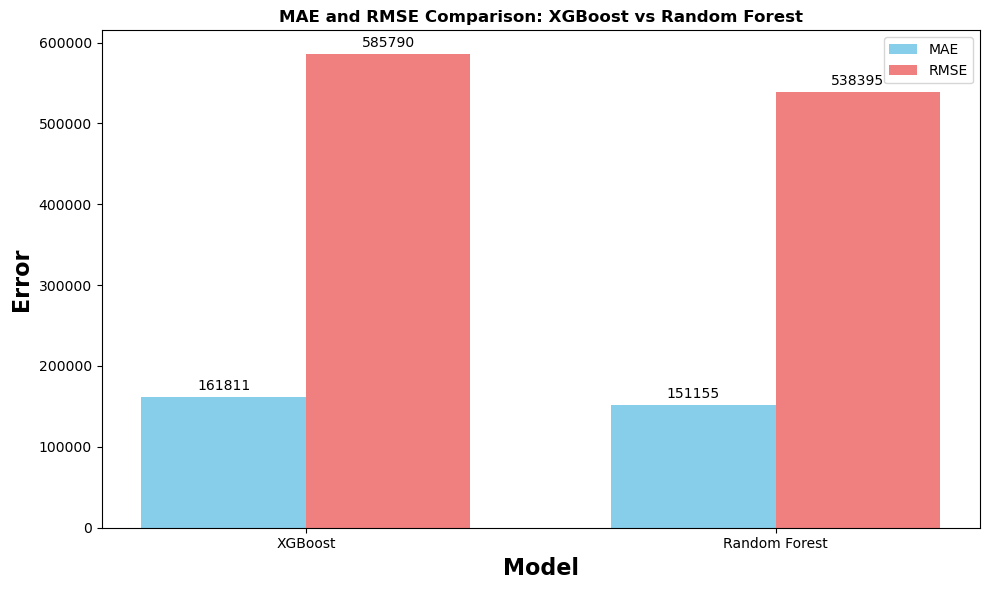

In [72]:
# Use the variables from the model code
models = ['XGBoost', 'Random Forest']
mae_values = [xgb_mae, rf_mae]
rmse_values = [xgb_rmse, rf_rmse]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, mae_values, width, label='MAE', color='skyblue')
bars2 = ax.bar(x + width/2, rmse_values, width, label='RMSE', color='lightcoral')

ax.set_xlabel('Model', fontweight = "bold", fontsize = 16)
ax.set_ylabel('Error', fontweight = "bold", fontsize = 16)
ax.set_title('MAE and RMSE Comparison: XGBoost vs Random Forest', fontweight = "bold")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

ax.bar_label(bars1, fmt='%.0f', padding=3)
ax.bar_label(bars2, fmt='%.0f', padding=3)

plt.tight_layout()
plt.show()


In [73]:

# Set reference date (one day after the last invoice date)
reference_date = data['InvoiceDate'].max() + dt.timedelta(days=1)

# Create RFM table
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                      # Frequency
    'TotalPrice': 'sum'                                          # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


#  Scale the RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


# APPLY KM-MEANS
# Choose the number of clusters (e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)



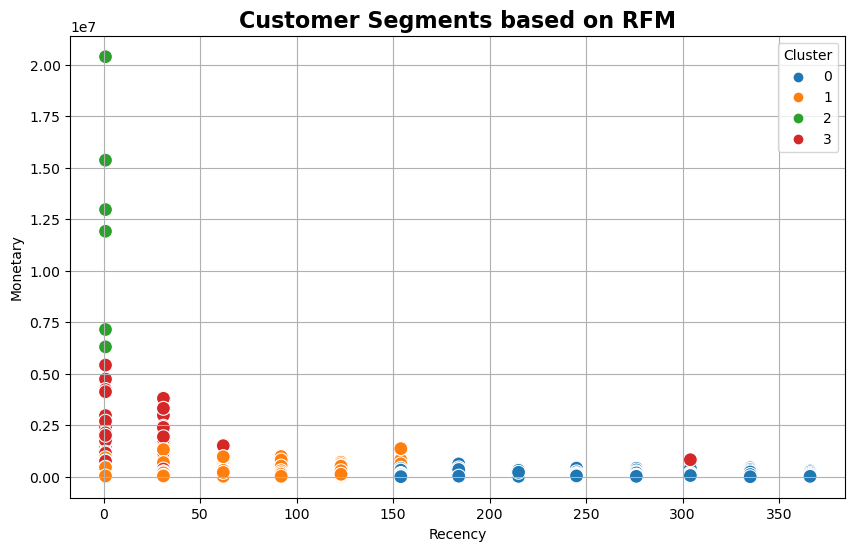

In [74]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='tab10', s=100)
plt.title('Customer Segments based on RFM', fontweight = "bold", fontsize = 16)
plt.grid(True)
plt.show()


## Label and Interpret Clusters

In [75]:
# Cluster profiling
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(1)

print("Cluster Profiles:")
print(cluster_profile)


Cluster Profiles:
         Recency  Frequency    Monetary
Cluster                                
0          248.2        1.8     71827.6
1           47.7        4.2    197407.9
2            1.0      153.5  12345024.6
3           14.8       25.2   1115413.9


#### Cluster 0: High frequency, high monetary → 🔥 Best Customers

#### Cluster 1: Low recency (very recent), but low frequency → 🧪 New Customers

#### Cluster 2: High recency (not recent), low frequency → ❄️ At Risk

#### Cluster 3: Medium frequency, medium spend → 😊 Loyal Customers

## Visualize Cluster Sizes

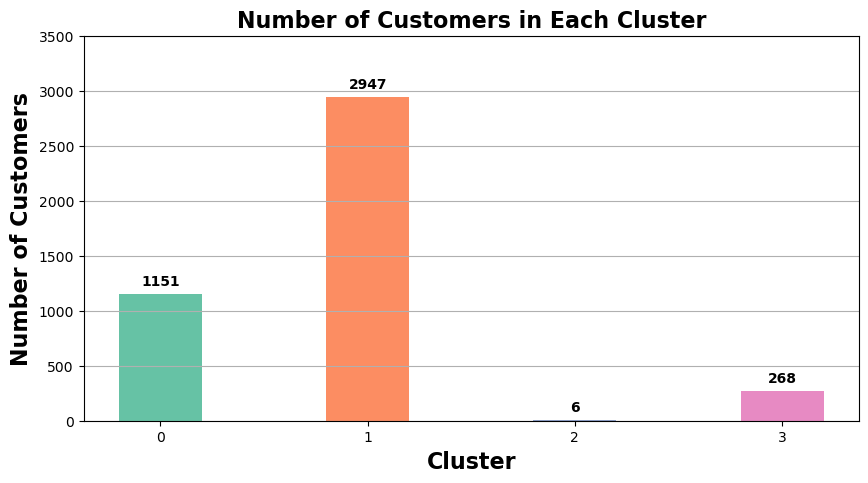

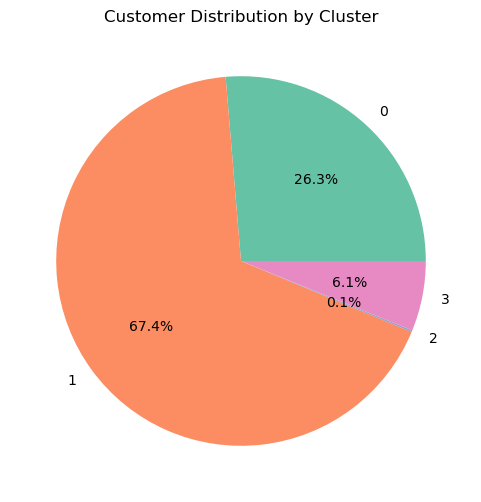

In [76]:
# Count of customers in each cluster
cluster_counts = rfm['Cluster'].value_counts().sort_index()

# Bar Chart
plt.figure(figsize=(10, 5))
bars = plt.bar(cluster_counts.index.astype(str), cluster_counts.values, color=sns.color_palette('Set2'), width=0.4)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 50, f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.title('Number of Customers in Each Cluster',fontweight = "bold", fontsize = 16)
plt.xlabel('Cluster', fontweight = "bold", fontsize = 16)
plt.ylabel('Number of Customers', fontweight = "bold", fontsize = 16)
plt.ylim(0, 3500)  # Limit y-axis
plt.grid(axis='y')
plt.show()


# Pie Chart
plt.figure(figsize=(6, 6))
plt.pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('Customer Distribution by Cluster')
plt.show()


# CONCLUSION


#### Cohort trends highlight the importance of retention and suggest timing for re-engagement campaigns.
#### RFM segmentation and clustering enable targeted marketing, customer prioritization, and personalized outreach.
#### Predictive models offer a scalable way to forecast customer value, helping in budget allocation and strategic decision-making.
#### Overall, this analysis builds a data-driven framework for understanding and optimizing customer lifecycle management.

